In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Exercise 1.

Here we wish to compute 
$$ \lambda _n (x) = \sum_{k=0}^n |\phi_{n,k}(x)| $$
where $\phi_{n,k}$ are the Lagrange coefficients

In [4]:
def getChebyNodes(num):
    k = np.arange(num)+1 # [1,2,...,num]
    # Calculate Tschebycheff nodes for [0,1]
    return np.cos((2*k-1)/(2*num)*np.pi)

def getLagrangeBasis(x,nodes,k):
    # Some vector reshaping to allow broadcasting
    nodes = np.reshape(nodes,(nodes.shape[0],1))
    N = nodes.shape[0]
    X = np.tile(x,[N-1,1])
    
    idx = np.arange(N) # [0,1,...,n-1] (indices)
    
    # Calculates product of (x-x_m)/(x_k-x_m) for all m != k
    return np.prod(np.tile(x,[N-1,1])-nodes[idx!=k],0)/np.prod(np.tile(nodes[k],[N-1,1])-nodes[idx!=k],0)
    
def lambdFct(x,N,nodes):
    # Calculate Lambda_n
    LamSum = 0
    for k in range(0,N):
        LamSum += np.abs(getLagrangeBasis(x,nodes,k))
    return LamSum    

In [4]:
# Largest n at which ||L_n|| is calculated
max_N = 100
# Initialize vector
lamb = np.zeros(max_N-1)
# Calculate ||L_n|| for various n
for N in range(1,max_N):
    # Get Tschebyscheff nodes
    nodes = getChebyNodes(N)
    # Calculate lambda_n associated with these nodes at x = -1
    lamb[N-1] = lambdFct(-1,N,nodes)


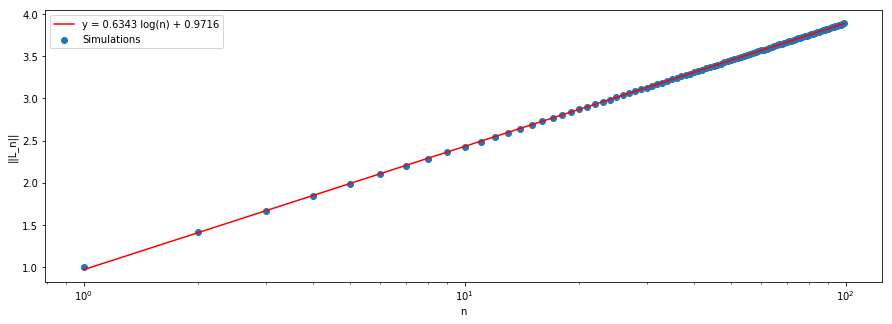

In [49]:
fig = plt.figure(figsize=(15,5))
plt.scatter(range(1,max_N),lamb)

# least square approximation w.r.t. log(n)
X = range(1,max_N)
X_log = np.log(X)
A = np.vstack([X_log, np.ones(len(X_log))]).T
C, y_int = np.linalg.lstsq(A, lamb)[0]
plt.plot(X,C*X_log+y_int,'-r')

plt.xscale('log')
plt.ylabel('||L_n||')
plt.xlabel('n')
    
plt.legend(['y = %.4f log(n) + %.4f' %(C,y_int), 'Simulations'])
plt.show()

Fitting the data to a log function yields the following least-square approximation:
$$ 0.6343 \log (n) + 0.9816 $$
Thus we estimate C = 0.6343

# Exercise 2.

Here, I use the Secant method on 
$$\lambda_n' = \sum_{k=0}^n \frac{\phi_{n,k}(x)}{|\phi_{n,k}(x)|} \phi'_{n,k}(x)$$
where
$$\phi'_{n,k} = \sum_{i=0,i\ne k}^n\frac{1}{x_k-x_i}\prod_{m=0,m\ne i,k}^n\frac{x-x_m}{x_k-x_m}$$

In [5]:
def NewtonsMethod(x,f,f_dif):
    # Terminate if x is sufficiently close to the root
    if(abs(f(x)) < 1e-8):
        return x
    else:
        # Recurse with map x -> x-f(x)/f'(x)
        return NewtonsMethod(x-f(x)/f_dif(x),f,f_dif)
    
def SecantMethod(x,y,f):
    if(abs(f(x)) < 1e-8):
        return x
    else:
        # Same as Newton's method, but f' is estimated
        f_dif = (f(x)-f(y))/(x-y)
        return SecantMethod(x-f(x)/f_dif,x,f)

# Derivative of Lagrange basis function
def getLagrangeBasisDiff(x,nodes,k):
    # Some vector reshaping to allow broadcasting
    nodes = np.reshape(nodes,(nodes.shape[0],1))
    N = nodes.shape[0]
    X = np.tile(x,[N-1,1])
    
    idx = np.arange(N) # [0,1,...,n-1] (indices)
    SUM = 0
    for i in range(0,N):
        if(i != k):
            # Calculates product of (x-x_m)/(x_k-x_m) for all m != k,i and adds it to SUM
            SUM += 1/(nodes[k]-nodes[i])*np.prod(np.tile(x,[N-2,1])-nodes[np.logical_and(idx!=k,idx!=i)],0)/np.prod(np.tile(nodes[k],[N-2,1])-nodes[np.logical_and(idx!=k,idx!=i)],0)
    return SUM

# Derivative of lambda, as described above
def lambdDiff(x,N,nodes):
    LamSum = 0
    for k in range(0,N):
        L = getLagrangeBasis(x,nodes,k)
        # Prevents division by 0
        L[L==0] = 1e-8
        LamSum += L*getLagrangeBasisDiff(x,nodes,k)/abs(L)
    return LamSum


In [143]:
# Calculate ||L_n|| at n from N0 to N_max
N0 = 5
N_max = 25
L = np.zeros(N_max-N0)
for N in range(N0,N_max):
    # Linearly space nodes between -1 and 1
    nodes = np.linspace(-1,1,N)
    # g = derivative of lambda
    g = lambda x: lambdDiff(x,N,nodes)
    # Initial two guesses for calculating initial derivate taken in first interval
    x0 = (nodes[0]+nodes[1])/2
    x1 = (2*nodes[0]+nodes[1])/3
    # Calculate root using secant method
    r = SecantMethod(x0,x1,g)
    # Calculate lambda at extremum (maximum)
    L[N-N0] = lambdFct(r,N,nodes)


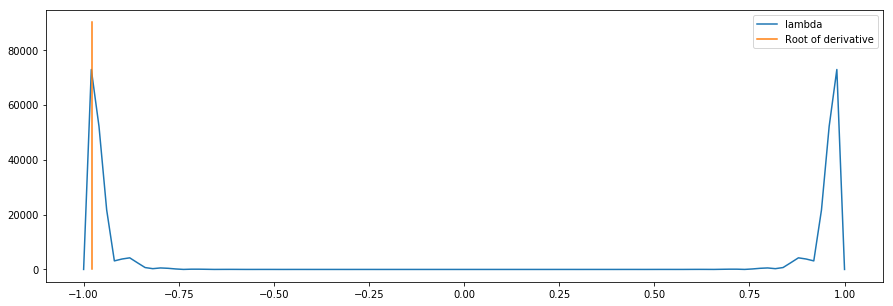

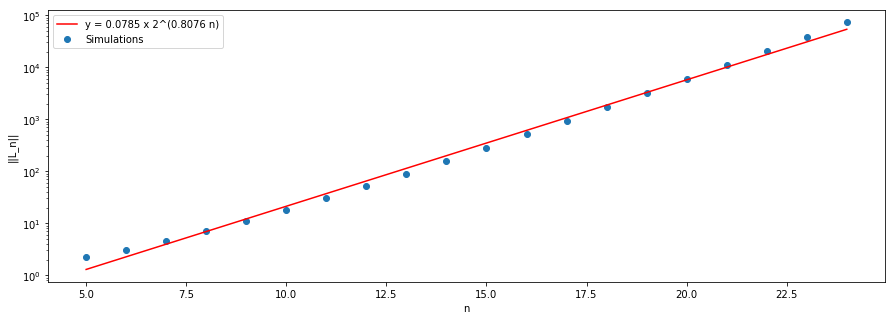

In [153]:
# Plot with log scale on x axis
fig = plt.figure(figsize=(15,5))
plt.plot(np.linspace(-1,1,100),lambdFct(np.linspace(-1,1,100),N,nodes))
plt.plot([r,r],[0,90000])
plt.legend(['lambda','Root of derivative'])
plt.show()


fig = plt.figure(figsize=(15,5))
plt.scatter(range(N0,N_max),L)
plt.yscale('log')

# least square approximation w.r.t. log(y)
X = range(N0,N_max)
A = np.vstack([X, np.ones(len(X))]).T
C, y_int = np.linalg.lstsq(A, np.log(L)/np.log(2))[0]
plt.plot(X,2**(C*X+y_int),'-r')

plt.ylabel('||L_n||')
plt.xlabel('n')
    
plt.legend(['y = %.4f x 2^(%.4f n)' %(2**y_int,C), 'Simulations'])

plt.show()

The first plot above shows we have correctly found the maximum of the function $\lambda_n(x)$.

By ploting $\log(\lambda_n(1))$ against n, we see that $||L_n||$ is exponential in n. By fitting an expontential to the data points we get the best-fit equation
$$ y = 0.0785 * 2^{0.8076n} $$

# Exercise 3.

We wish to calculate 
$$ ||S_n|| = \int _0^\pi \left | \frac{ \sin ((n+1/2)\theta) }{ 2 \sin (1/2\theta) } \right |$$


In [18]:
# Integrand in above integral
def DirKer(theta,n):
    theta[theta == 0] = 1e-8
    return np.sin((n+1/2)*theta)/(2*np.sin(1/2*theta))

# Trapezoid rule of numerical integration
def trapInt(f,nodes):
    S = 0
    for i in range(0,len(nodes)-1):
        S += np.abs(nodes[i+1]-nodes[i])*(f(nodes[i+1])+f(nodes[i]))/2
    return S

In [47]:
N_max = 100
N0 = 1
S = np.zeros(N_max-N0)
# Calculate ||S_n|| for n = N0 to N_max
for N in range(N0,N_max):
    # f = integrand for n = N
    f = lambda x: abs(DirKer(np.array(x),N))
    # The zeros of f
    nodes = (np.arange(N))*np.pi/(N+0.5)
    # Add the end points (pi) to the nodes
    nodes = np.append(nodes,np.pi)
    # Calculate the integral by applying the trapizoid integration with 
    # 100 sub interval in each interval defined by the zeros of the function and sum
    for i in range(0,len(nodes)-1):
        S[N-N0] += trapInt(f,np.linspace(nodes[i],nodes[i+1],100))

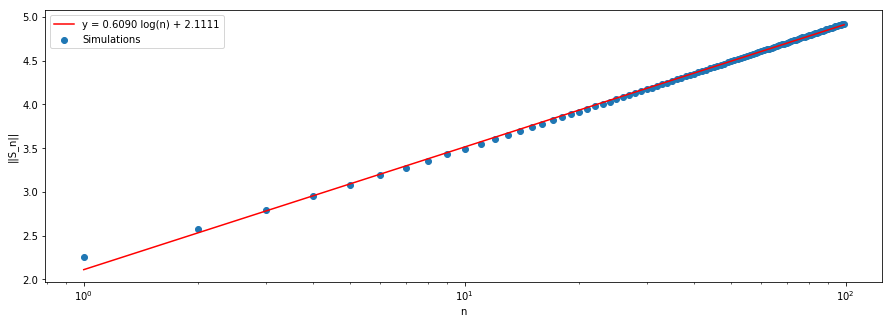

In [50]:
fig = plt.figure(figsize=(15,5))
plt.scatter(range(N0,N_max),S)
plt.xscale('log')

# least square approximation w.r.t. log(n)
X = range(N0,N_max)
X_log = np.log(X)
A = np.vstack([X_log, np.ones(len(X_log))]).T
C, y_int = np.linalg.lstsq(A, S)[0]
plt.plot(X,C*X_log+y_int,'-r')

plt.ylabel('||S_n||')
plt.xlabel('n')
    
plt.legend(['y = %.4f log(n) + %.4f' %(C,y_int), 'Simulations'])


plt.show()

Fitting the data to a log function yields the following least-square approximation:
$$ ||S_n|| = 0.609 \log (n) + 2.111 $$
Thus we estimate C = 0.609

# Exercise 4.

We wish to calculate 
$$\int_{-1}^{1} \left | \sum_{k=0}^n a_k P_k(x) \right | $$
where $P_k(x)$ is the kth Legendre polynomial

In [7]:
# The integrand of the above integral with specified n evalulated at x
def LegPolySum(x,n):
    S = 0
    for k in range(0,n+1):
        # Get kth Legendre polynomial
        f = np.polynomial.legendre.Legendre.basis(k)
        S += (a_k(k)*f(x))
    return abs(S)

# returns a_k to multiply P_k with
def a_k(k):
    return k+0.5

In [23]:
N_max = 50
N0 = 0
nodes = [-1,1]
S2 = np.zeros(N_max-N0)
# Compute integral with LegPolySum at 
r = []
for N in range(N0,N_max):
    # Use trapezoid integration with 10 subinterval in each major interval defined by 
    # the roots of the Legendre polynomials
    nodes = np.append(r,np.polynomial.legendre.Legendre.basis(N).roots())
    nodes = np.sort(nodes)
    for i in range(0,len(nodes)-1):
        S2[N-N0] += trapInt(lambda x: LegPolySum(x,N),np.linspace(nodes[i],nodes[i+1],10))

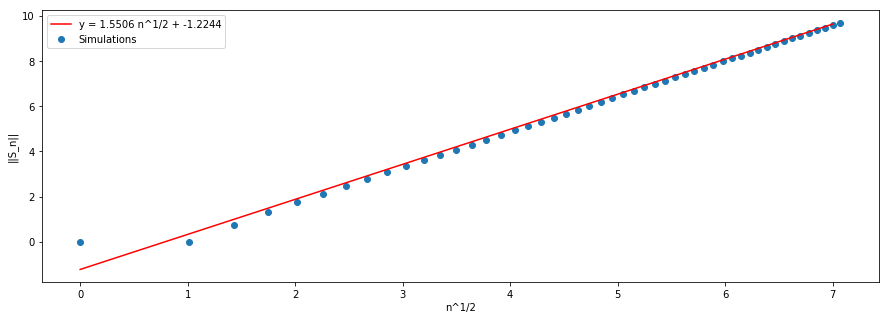

In [24]:
fig = plt.figure(figsize=(15,5))
plt.scatter(np.linspace(N0,N_max,N_max-N0)**0.5,S2)

# least square approximation w.r.t. \sqrt(n)
X = range(N0,N_max)
X_sqrt = np.sqrt(X)
A = np.vstack([X_sqrt, np.ones(len(X_sqrt))]).T
C, y_int = np.linalg.lstsq(A, S2)[0]
plt.plot(X_sqrt,C*X_sqrt+y_int,'-r')

plt.ylabel('||S_n||')
plt.xlabel('n^1/2')
    
plt.legend(['y = %.4f n^1/2 + %.4f' %(C,y_int), 'Simulations'])


plt.show()

Fitting the data to a square-root function yields the following least-square approximation:
$$ ||S_n|| = 1.5506 \sqrt{n} - 1.2244 $$
Thus we estimate C = 1.5506

# Exercise 5.

Here we want to calculate 
$$ || Q_n || = \sum_{k=0}^n \left | \int_a^b \phi _{n,k} \right | $$
where $\phi_{n,k}$ is the k-th Lagrange basis function assoiated to the nodes $x_0,...,x_n$

In [25]:
N_max = 50
N0 = 1
Q = np.zeros(N_max-N0)
# Calculate ||Q_n|| for n = N0 to N_max
for N in range(N0,N_max):
    # Take N+1 linearly spaced nodes from 0 to 1
    nodes = np.linspace(0,1,N+1)
    # Calculate the integral for each k
    for k in range(0,N+1):
        # For each large interval [i,i+1] use the trapezoid rule on 10 sub-intervals
        I = 0
        for i in range(0,len(nodes)-1):
            I += trapInt(lambda x: getLagrangeBasis(x,nodes,k),np.linspace(nodes[i],nodes[i+1],10))
        Q[N-N0] += abs(I)


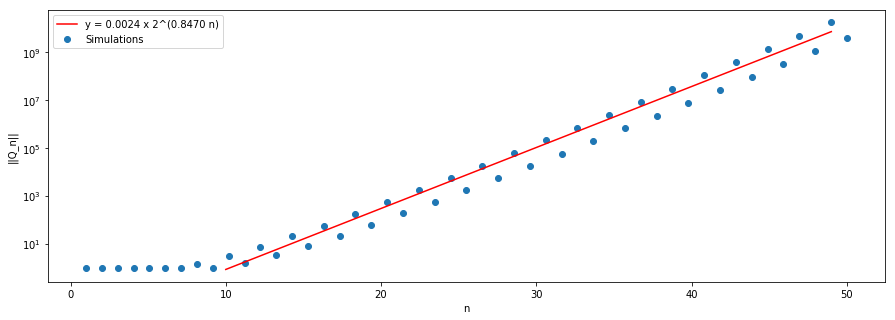

In [26]:
fig = plt.figure(figsize=(15,5))
plt.scatter(np.linspace(N0,N_max,N_max-N0),Q)
plt.yscale('log')

# least square approximation using log(y)
X = range(10,N_max)
A = np.vstack([X, np.ones(len(X))]).T
C, y_int = np.linalg.lstsq(A, np.log(Q[9:])/np.log(2))[0]

plt.plot(X,2**(C*X+y_int),'-r')

plt.ylabel('||Q_n||')
plt.xlabel('n')
    
plt.legend(['y = %.4f x 2^(%.4f n)' %(2**y_int,C), 'Simulations'])

plt.show()

By plotting the data with a log scale on the y-axis, it seems that $||Q_n||$ grows expontentially with n.